# Trabajo Práctico 1: Propiedades en Venta - Gradient Boost

## Grupo 11 - "Los Outliers"
- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

## Libraries

In [1]:
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load del DataFrame a utilizar

Cargo los datos con los avisos clasificados con su tipo de precio. También fijamos una semilla para usarla a lo largo de toda la notebook.

In [3]:
df = pd.read_csv("https://drive.google.com/uc?id=1GhsJwy29gS2y_HibaDeChkx-ozSc2Qc3", index_col=0)
semilla = 137

## Limpieza de los datos

Lo primero que hacemos para poder entrenar el modelo de Gradient Boost es seleccionar las columnas del dataframe que consideramos más relevantes. Hay algunas, como el `id` y  `property_title`, que claramente no aportan información útil. También, removemos la columna de `property_price` por ser el target, y las columnas de `precio_m2` y `tipo_precio` por estar íntimamente relacionadas. Finalmente, usamos un *label encoder* para las columnas `neighbourhood` y `property_type`, que necesitan ser numéricas para que las pueda considerar el modelo. Dado que queremos evitar tener muchas columnas, optamos por no usar One Hot Encoding.

In [4]:
from sklearn.preprocessing import LabelEncoder

df_features = df[[
    "latitud",
    "longitud",
    "neighbourhood",
    "property_type",
    "property_rooms",
    "property_bedrooms",
    "property_surface_total",
    "property_surface_covered"]]

df_target = df[["property_price"]]

encoder = LabelEncoder()
df_features.loc[:, 'property_type'] = encoder.fit_transform(df_features.property_type.values)
df_features.loc[:, 'neighbourhood'] = encoder.fit_transform(df_features.neighbourhood.values)

Luego, genero los conjuntos de train y test.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features, df_target.values.ravel(), test_size=0.20, random_state=semilla)

## Entrenamiento de un primer modelo

Empezamos entrenando un modelo base, para luego entrenar otro optimizando sus hiperparámetros y poder compararlos.

In [6]:
from sklearn import ensemble

regressor = ensemble.GradientBoostingRegressor(random_state=semilla)
regressor.fit(X_train, y_train)

GradientBoostingRegressor(random_state=137)

Observo las métricas del modelo en testing y en training.

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

prediccion_train_basic = regressor.predict(X_train)
mse = mean_squared_error(y_train, prediccion_train_basic)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, prediccion_train_basic)

print("\nMétricas con el conjunto de training.\n")
print("RMSE (train): {:.4f}".format(rmse))
print("MSE (train): {:.4f}".format(mse))
print("R2 (train): {:.4f}".format(r2))

prediccion_test_basic = regressor.predict(X_test)
mse = mean_squared_error(y_test, prediccion_test_basic)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, prediccion_test_basic)

print("\nMétricas con el conjunto de testing.\n")
print("RMSE (test): {:.4f}".format(rmse))
print("MSE (test): {:.4f}".format(mse))
print("R2 (test): {:.4f}".format(r2))


Métricas con el conjunto de training.

RMSE (train): 58088.2673
MSE (train): 3374246792.6480
R2 (train): 0.8096

Métricas con el conjunto de testing.

RMSE (test): 59288.4529
MSE (test): 3515120646.7748
R2 (test): 0.8008


## Randomized Search

Una vez entrenado un modelo base para poder comparar luego, buscamos entrenar un nuevo modelo optimizando los siguientes hiperparámetros:

* `n_stimators`: Cantidad de árboles máximos que pueden estar presentes en el modelo.
* `max_depth`: Máximo nivel de profundidad que puede tener cada árbol.
* `learning_rate`: Valor utilizado para disminuir que tanto contribuye cada árbol al resultado final.
* `loss`: Función de perdida a optimizar. Vamos a probar con el error cuadrático, el error absoluto y "huber", que es una combinación de ambos.


In [8]:
params_grid = {
    "n_estimators": range(20, 50),
    "max_depth": [8, 16, 24, 32],
    "learning_rate": [0.01, 0.1, 0.2],
    "loss": ["squared_error", "absolute_error"],
}

De manera similar a como lo hicimos en la parte de clasificación, usamos Stratified KFold porque hay una distribución dispareja en las categorías del target que queremos tratar de mantener en cada fold. También, elegimos usar 5 folds.

Por otro lado, y también como lo hicimos en la etapa de clasificación, utilizamos RandomizedSearch en lugar de GridSearch para ahorrar tiempo.

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

folds=5
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=semilla)

base_regressor = ensemble.GradientBoostingRegressor(random_state=semilla)

randomcv = RandomizedSearchCV(
    estimator=base_regressor,
    scoring="r2",
    param_distributions=params_grid,
    n_iter=10,
    cv=kfoldcv,
    random_state=semilla,
    verbose=2
)

Para entrenar al modelo utilizamos el método fit con el set de entrenamiento ya transformado:

```python
randomcv.fit(X_train, y_train)
```

Sin embargo, luego de haber ejecutado este método con anterioridad, ya contamos con el modelo más óptimo encontrado, que ha sido exportado en un archivo de joblib, lo que nos permite simplemente cargar el archivo y no tener que volver a entrenar todos los modelos con todos los parámetros que probamos.

In [9]:
from joblib import load

best_regressor = load("gradient_boost.joblib")
best_regressor.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'absolute_error',
 'max_depth': 32,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 41,
 'n_iter_no_change': None,
 'random_state': 137,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Finalmente observamos las estadísticas del modelo.

In [10]:
prediccion_train_best = best_regressor.predict(X_train)
mse = mean_squared_error(y_train, prediccion_train_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, prediccion_train_best)

print("Métricas con el conjunto de training.\n")
print("RMSE: {:.4f}".format(rmse))
print(" MSE: {:.4f}".format(mse))
print("  R2: {:.4f}".format(r2))

prediccion_test_best = best_regressor.predict(X_test)
mse = mean_squared_error(y_test, prediccion_test_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, prediccion_test_best)

print("\nMétricas con el conjunto de testing.\n")
print("RMSE: {:.4f}".format(rmse))
print(" MSE: {:.4f}".format(mse))
print("  R2: {:.4f}".format(r2))

Métricas con el conjunto de training.

RMSE: 15911.6112
 MSE: 253179371.7982
  R2: 0.9857

Métricas con el conjunto de testing.

RMSE: 42570.4263
 MSE: 1812241199.3261
  R2: 0.8973


Si comparamos el rendimiento de este modelo con el que utilizaba los parámetros por defecto, notamos que aunque el anterior ya tenía un rendimiento significativamente positivo, este lo mejora aún más. Por el resultado de las métricas en el conjunto de training, especialmente $R^2$, podríamos sospechar que el modelo tiene overfitting, sin embargo, también muestra un desempeño robusto en el conjunto de test ante datos que nunca ha visto.

Si utilizamos scatter plots para comparar las predicciones con los precios reales, es fácil ver lo mucho mejor adaptado que está al conjunto de training.

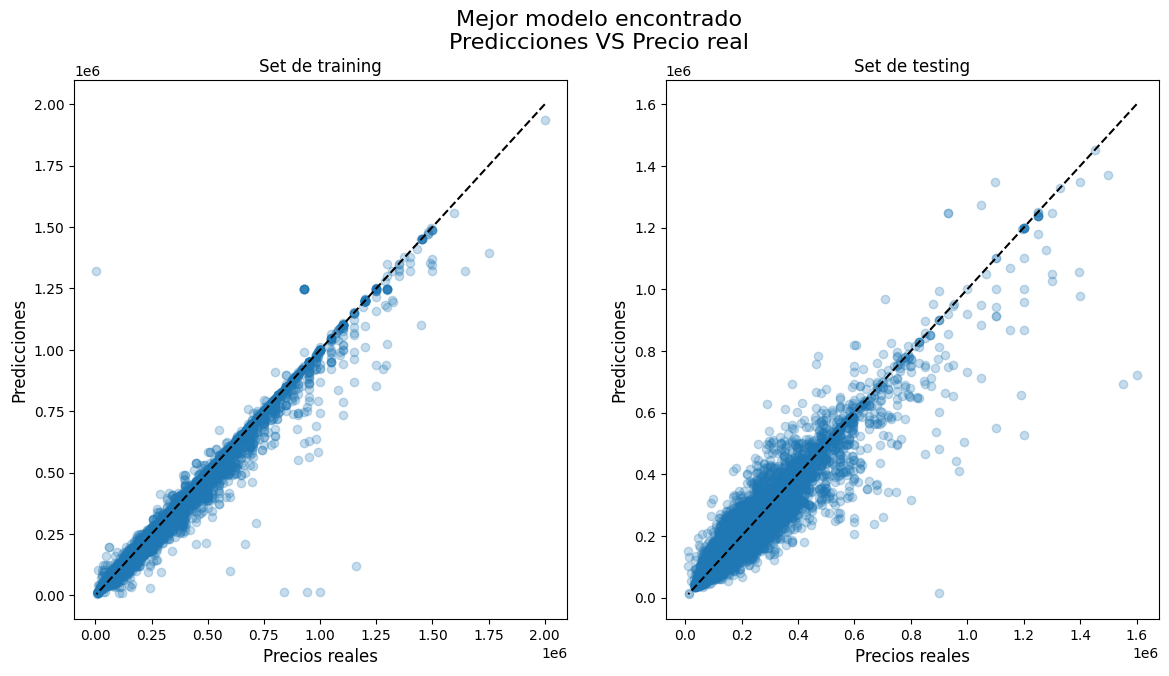

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].set_title("Set de training")
axs[0].scatter(y_train, prediccion_train_best, alpha=0.25)

p1 = max(max(prediccion_train_best), max(y_train))
p2 = min(min(prediccion_train_best), min(y_train))

axs[0].plot([p1, p2], [p1, p2], 'k--')
axs[0].set_xlabel('Precios reales', fontsize=12)
axs[0].set_ylabel('Predicciones', fontsize=12)

axs[1].set_title("Set de testing")
axs[1].scatter(y_test, prediccion_test_best, alpha=0.25)

p1 = max(max(prediccion_test_best), max(y_test))
p2 = min(min(prediccion_test_best), min(y_test))

axs[1].plot([p1, p2], [p1, p2], 'k--')
axs[1].set_xlabel('Precios reales', fontsize=12)
axs[1].set_ylabel('Predicciones', fontsize=12)

fig.suptitle("Mejor modelo encontrado\nPredicciones VS Precio real", fontsize=16)

plt.axis('tight')
plt.show()

Si las predicciones fuesen perfectas, veríamos como se alinean perfectamente con la línea punteada trazada en ambos gráficos. Con el set de training, vemos que los datos se alinean bastante mejor que con el de testing, lo cual se corresponde con los resultados de las métricas. En particular con la métrica de $R^2$, que era mucho mas elevada para el test de training, cuyas predicciones se acercan más a la línea punteada.
Para comparar las mejoras de nuestro modelo luego de optimizar sus hiperparámetros, podemos comparar estos gráficos con los del primer modelo que entrenamos.

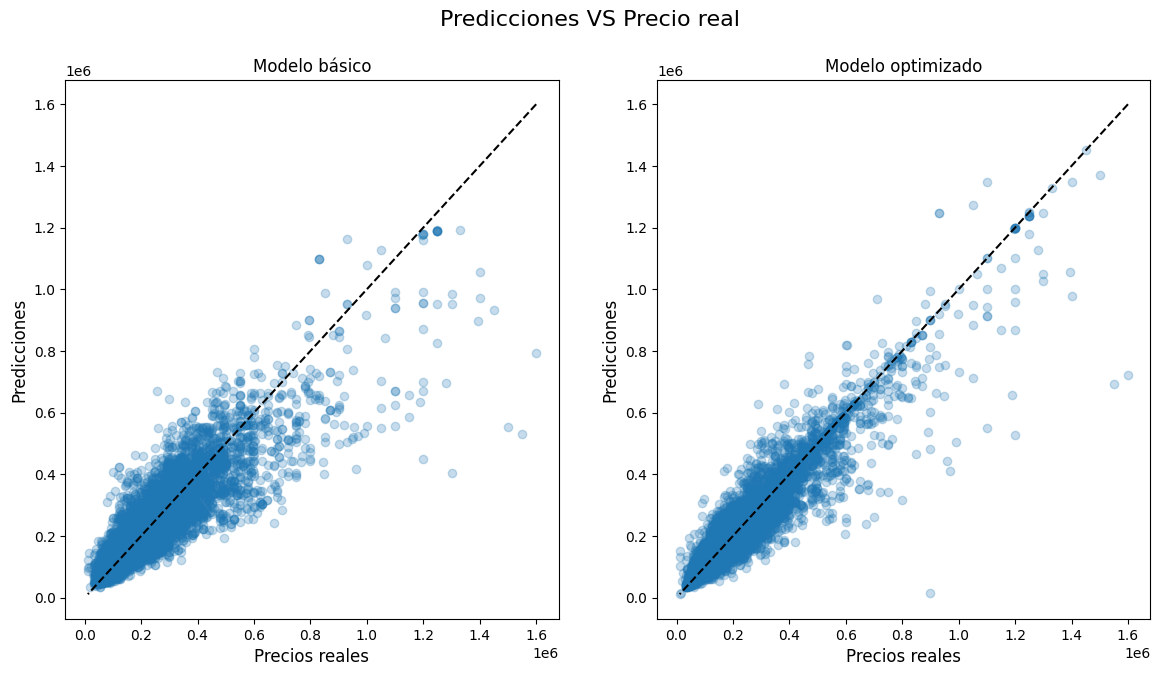

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].set_title("Modelo básico")
axs[0].scatter(y_test, prediccion_test_basic, alpha=0.25)

p1 = max(max(prediccion_test_basic), max(y_test))
p2 = min(min(prediccion_test_basic), min(y_test))

axs[0].plot([p1, p2], [p1, p2], 'k--')
axs[0].set_xlabel('Precios reales', fontsize=12)
axs[0].set_ylabel('Predicciones', fontsize=12)

axs[1].set_title("Modelo optimizado")
axs[1].scatter(y_test, prediccion_test_best, alpha=0.25)

p1 = max(max(prediccion_test_best), max(y_test))
p2 = min(min(prediccion_test_best), min(y_test))

axs[1].plot([p1, p2], [p1, p2], 'k--')
axs[1].set_xlabel('Precios reales', fontsize=12)
axs[1].set_ylabel('Predicciones', fontsize=12)

fig.suptitle("Predicciones VS Precio real", fontsize=16)

plt.axis('tight')
plt.show()

Se ve una mejora en el segundo gráfico en tanto los valores están menos dispersos en general. Esto también se ve con la métrica $R^2$, que en el primero es de 0.8008 y en el segundo es de 0.8973.